In [1]:
##Our import: 
import nltk
from nltk.probability import ConditionalFreqDist
import pandas as pd
import math
from nltk import word_tokenize
import numpy as np

from sklearn.feature_extraction import DictVectorizer

##Our defines: 
q1Verbose=1

### Q1. Document Classification
#### Q1.1. Reuters Dataset

##### Q1.1.1 Turn the code of the Sklearn tutorial above into a notebook.

This code is taken from the out of core classification guide given in the assigmnent. 
http://scikit-learn.org/dev/auto_examples/applications/plot_out_of_core_classification.html#example-applications-plot-out-of-core-classification-py


Test set is 469 documents (49 positive)
      NB Multinomial classifier : 	   969 train docs (   155 positive)    469 test docs (    49 positive) accuracy: 0.896 in 2.01s (  482 docs/s)
                 SGD classifier : 	   969 train docs (   155 positive)    469 test docs (    49 positive) accuracy: 0.938 in 2.04s (  475 docs/s)
  Passive-Aggressive classifier : 	   969 train docs (   155 positive)    469 test docs (    49 positive) accuracy: 0.932 in 2.04s (  474 docs/s)
          Perceptron classifier : 	   969 train docs (   155 positive)    469 test docs (    49 positive) accuracy: 0.945 in 2.05s (  473 docs/s)


      NB Multinomial classifier : 	  3816 train docs (   557 positive)    469 test docs (    49 positive) accuracy: 0.910 in 5.09s (  749 docs/s)
                 SGD classifier : 	  3816 train docs (   557 positive)    469 test docs (    49 positive) accuracy: 0.966 in 5.10s (  748 docs/s)
  Passive-Aggressive classifier : 	  3816 train docs (   557 positive)    469 test

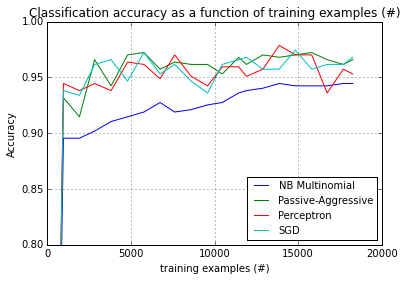

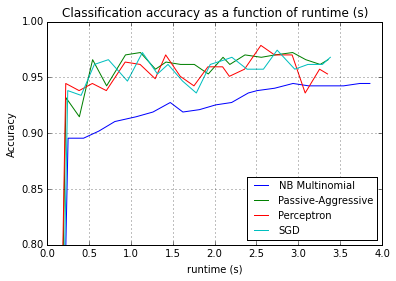

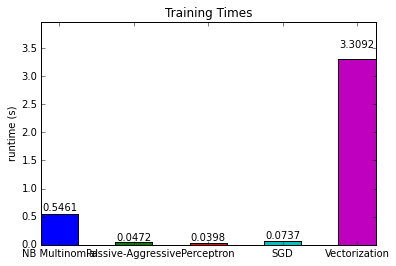

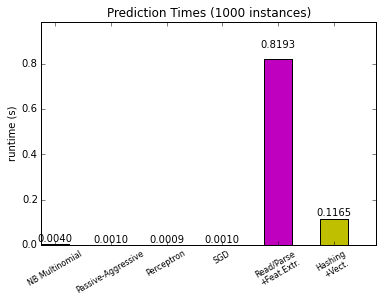

In [2]:
# Authors: Eustache Diemert <eustache@diemert.fr>
#          @FedericoV <https://github.com/FedericoV/>
# License: BSD 3 clause

from __future__ import print_function

from glob import glob
import itertools
import os.path
import re
import tarfile
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.externals.six.moves import html_parser
from sklearn.externals.six.moves import urllib
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB




def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()

%matplotlib inline
###############################################################################
# Reuters Dataset related routines
###############################################################################


class ReutersParser(html_parser.HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        html_parser.HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                print('\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb),
                      end='')

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urllib.request.urlretrieve(DOWNLOAD_URL, filename=archive_path,
                                   reporthook=progress)
        if _not_in_sphinx():
            print('\r', end='')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc


###############################################################################
# Main
###############################################################################
# Create the vectorizer and limit the number of features to a reasonable
# maximum
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18,
                               non_negative=True)


# Iterator over parsed Reuters SGML files.
data_stream = stream_reuters_documents()

# We learn a binary classification between the "acq" class and all the others.
# "acq" was chosen as it is more or less evenly distributed in the Reuters
# files. For other datasets, one should take care of creating a test set with
# a realistic portion of positive instances.
all_classes = np.array([0, 1])
positive_class = 'acq'

# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}


def get_minibatch(doc_iter, size, pos_class=positive_class):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """
    data = [(u'{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)


def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)


# test data statistics
test_stats = {'n_test': 0, 'n_test_pos': 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 1000
tick = time.time()
X_test_text, y_test = get_minibatch(data_stream, 1000)
parsing_time = time.time() - tick
tick = time.time()
X_test = vectorizer.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats['n_test'] += len(y_test)
test_stats['n_test_pos'] += sum(y_test)
print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))


def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

get_minibatch(data_stream, n_test_documents)
# Discard test set

# We will feed the classifier with mini-batches of 1000 documents; this means
# we have at most 1000 docs in memory at any time.  The smaller the document
# batch, the bigger the relative overhead of the partial fit methods.
minibatch_size = 1000

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

# Main loop : iterate on mini-batchs of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = vectorizer.transform(X_train_text)
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')


###############################################################################
# Plot results
###############################################################################


def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)

rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats['runtime_history'])
    plot_accuracy(runtime, accuracy, 'runtime (s)')
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = []
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['total_fit_time'])

cls_runtime.append(total_vect_time)
cls_names.append('Vectorization')
bar_colors = rcParams['axes.color_cycle'][:len(cls_names)]

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Training Times')


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')

autolabel(rectangles)
plt.show()

# Plot prediction times
plt.figure()
#fig = plt.gcf()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['prediction_time'])
cls_runtime.append(parsing_time)
cls_names.append('Read/Parse\n+Feat.Extr.')
cls_runtime.append(vectorizing_time)
cls_names.append('Hashing\n+Vect.')
bar_colors = rcParams['axes.color_cycle'][:len(cls_names)]

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Prediction Times (%d instances)' % n_test_documents)
autolabel(rectangles)
plt.show()

##### Q1.1.2 Explore how many documents are in the dataset, how many categories, how many documents per categories, provide mean and standard deviation, min and max. (Hint: use the pandas library to explore the dataset, use the dataframe.describe() method.)


In [3]:
#From the code, accessing the reuters document data base. 
data_stream = stream_reuters_documents()
#Experimenting with functions given in hint. 
df = pd.DataFrame(data_stream)
print("The type of df is: ", type(df))
df

The type of df is:  <class 'pandas.core.frame.DataFrame'>


body  \
0      Chrysler Corp said car sales for the March 21-...   
1      Compaq Computer Corp, IBM's chief rival in the...   
2      <Noranda Inc> said production will remain shut...   
3      The Canadian government's budget deficit rose ...   
4      CIS Technologies Inc said it executed a formal...   
5      Qtly div 42 cts vs 41.5 cts prior Payable APri...   
6      Colombia's cost of living index rose 2.71 pct ...   
7      The Federal Home Loan Bank Board said home mor...   
8      The New York Stock Exchange said a seat on the...   
9                                                          
10     Beneficial Corp said the sale of its American ...   
11     European options exchanges will see spectacula...   
12     Tierco Group INc said it sold at par to the Ku...   
13     Shr 5.56 dlrs vs 3.88 dlrs Net 47.5 mln vs 33....   
14     California Micro Devices Corp said an addition...   
15     Stewart INformation Services Corp said it resc...   
16     FIserve Inc said 14 savings and loans with 1.5...   
17     Mony Real Estate Investors Trust said its inve...   
18     Canadian narrowly-defined money supply M-1 fel...   
19     Copley Properties Inc said the company will in...   
20     The United Food And Commercial Workers said th...   
21     Pan Am Corp's Pan American World Airways said ...   
22     FCS Laboratories Inc said merger discussions w...   
23     The White House said the rise in interest rate...   
24     Shr loss nine cts Net loss 1.4 mln Revs 630,11...   
25     Shr 1.1 cts vs 1.7 cts Net 26,708 vs 35,084 Re...   
26     Shr nine cts vs 19 cts Net 188,000 vs 362,000 ...   
27                                                         
28                                                         
29     Burlington Northern Inc said its Burlington No...   
...                                                  ...   
21548  Hundreds of marines were on alert at 11 key Br...   
21549  Indonesia's Armed Forces Commander General Ben...   
21550  The suspension of Ecuador's crude oil shipment...   
21551  Any European Community decision to liberalise ...   
21552  China has raised the prices it pays farmers fo...   
21553  Australia sold 180,000 tonnes of raw sugar to ...   
21554  Thai natural rubber exports rose to 763,331 to...   
21555  Australian beef output declined to 104,353 ton...   
21556  Increased federal government borrowing needs a...   
21557  Philippine President Corazon Aquino swore in f...   
21558  Kenya and Shenzhen Electronics Group (SEG) of ...   
21559  The Soviet Union has agreed to cut its coking ...   
21560  <Placer Pacific Ltd> said it hopes the Papua N...   
21561  The special prosecutor in the Iran arms scanda...   
21562  The Bangladesh trade deficit narrowed to 1.91 ...   
21563  The outlook for Australian industrial investme...   
21564  The central bank has issued 12 billion Taiwan ...   
21565  Three Japanese credit rating agencies are ente...   
21566  Most commodity agreements are close to collaps...   
21567  Swiss industrial output rose nine pct in the f...   
21568  Japanese securities houses are thinking of all...   
21569  The United States has openly attacked Japan's ...   
21570  The Asian dollar market continued to expand in...   
21571  Singapore's M-1 money supply rose 3.7 pct duri...   
21572  The value of China's industrial output in Janu...   
21573  The Dutch central bank said it has accepted bi...   
21574  Union Bank of Finland is issuing a 10 billion ...   
21575  Japanese customers have bought nearly six mln ...   
21576  Imperial Chemical Industries Plc <ICI.L> said ...   
21577  Unilever Australia Ltd is issuing 40 mln Austr...   

                                                   title  \
0              CHRYSLER <C> LATE MARCH U.S. CAR SALES UP   
1               WALL STREET STOCKS/COMPAQ COMPUTER <CPQ>   
2                   NORANDA SETS TEMPORARY MINE SHUTDOWN   
3                 CANADA BUDGET DEFICIT RISES IN JANUARY   
4       CIS TECHNOLOGIES<CIH> T

#### How many documents in the dataset? 

In [4]:
df['title'].describe()['count']


21578

In [5]:
df['body']

0        Chrysler Corp said car sales for the March 21-...
1        Compaq Computer Corp, IBM's chief rival in the...
2        <Noranda Inc> said production will remain shut...
3        The Canadian government's budget deficit rose ...
4        CIS Technologies Inc said it executed a formal...
5        Qtly div 42 cts vs 41.5 cts prior Payable APri...
6        Colombia's cost of living index rose 2.71 pct ...
7        The Federal Home Loan Bank Board said home mor...
8        The New York Stock Exchange said a seat on the...
9                                                         
10       Beneficial Corp said the sale of its American ...
11       European options exchanges will see spectacula...
12       Tierco Group INc said it sold at par to the Ku...
13       Shr 5.56 dlrs vs 3.88 dlrs Net 47.5 mln vs 33....
14       California Micro Devices Corp said an addition...
15       Stewart INformation Services Corp said it resc...
16       FIserve Inc said 14 savings and loans with 1.5.

There are 21,578 as seen below. 

In [6]:
#Some exploring of dataset: 
if q1Verbose:
    print(list(df))
    print(df['body'].describe())
    # Since df['topics'].descibe() does not work, let's just print. 
    print(df['topics'])
    print(type(df['topics']))

['body', 'title', 'topics']
count     21578
unique    18763
top            
freq       2535
Name: body, dtype: object
0                                         [usa]
1                                         [usa]
2                              [copper, canada]
3                                      [canada]
4                       [acq, usa, switzerland]
5                                   [earn, usa]
6                               [cpi, colombia]
7                               [interest, usa]
8                                   [usa, nyse]
9                        [money-supply, canada]
10                                   [acq, usa]
11                     [netherlands, ase, cboe]
12                                        [usa]
13                               [earn, canada]
14                                        [usa]
15                                        [usa]
16                                        [usa]
17                                        [usa]
18                

#### Each document can belong to a few topics (we interperted topics for categories). We will feed all information into a FreqDist and receive statistics.

As implied, this means a document can appear in several documents. 

In [7]:
#Create a list of all occurences of all topics and feed to FreqDist. 
freq_dist = nltk.FreqDist(sum(list(df['topics']), []))

#### How many categories: 

In [8]:
category_set=set(sum(list(df['topics']), []))
num_of_categories = len(category_set)
print("The number of categories is: ",num_of_categories)

The number of categories is:  445


Since we are using a Frequency distribution, the number of categories can also be retrieved by: 


In [9]:
len(freq_dist)


445

#### How many documents per category: 
Since we are using a Frequency distribution, the number of documents per category 
is the value in freq_dist[category]. 

We can print a list of all categories and the number of documents in them. 

In [10]:
cat_numOfDocs = [(category, freq_dist[category]) for category in category_set]
for pair in cat_numOfDocs[:10]: 
    print('Category: ', pair[0], 'has ', pair[1], 'Docs')

Category:  cavaco-silva has  4 Docs
Category:  turkey has  64 Docs
Category:  duisenberg has  2 Docs
Category:  hawke has  7 Docs
Category:  bahamas has  1 Docs
Category:  veg-oil has  137 Docs
Category:  morocco has  18 Docs
Category:  efta has  1 Docs
Category:  iwc-wheat has  4 Docs
Category:  johnston has  1 Docs


####  Provide mean and standard deviation, min and max. 
Mean: Mean number of documents per categorie. 

In [11]:
[num_of_docs for _, num_of_docs in cat_numOfDocs]

[4,
 64,
 2,
 7,
 1,
 137,
 18,
 1,
 4,
 1,
 3,
 2,
 2,
 10,
 2,
 40,
 8,
 27,
 76,
 223,
 112,
 7,
 513,
 61,
 69,
 1,
 18,
 12,
 2,
 32,
 97,
 12,
 3,
 49,
 8,
 10,
 18,
 7,
 1138,
 60,
 9,
 6,
 5,
 128,
 8,
 44,
 3,
 27,
 16,
 51,
 628,
 6,
 1,
 4,
 3,
 4,
 6,
 7,
 19,
 4,
 2,
 69,
 9,
 35,
 37,
 3,
 3,
 349,
 3,
 2,
 1,
 25,
 56,
 1,
 306,
 2,
 3,
 270,
 1,
 3,
 3,
 25,
 53,
 17,
 4,
 1,
 7,
 28,
 10,
 27,
 12542,
 179,
 2,
 115,
 14,
 11,
 1,
 3,
 145,
 1,
 4,
 4,
 2,
 8,
 38,
 5,
 120,
 33,
 2,
 1,
 1,
 136,
 10,
 99,
 63,
 2,
 2,
 1,
 1,
 2,
 2,
 10,
 5,
 16,
 2,
 47,
 1,
 4,
 2,
 1,
 3,
 801,
 23,
 8,
 60,
 17,
 12,
 10,
 3,
 40,
 16,
 4,
 2,
 28,
 63,
 7,
 3,
 3,
 35,
 17,
 1,
 5,
 65,
 1,
 163,
 135,
 1,
 6,
 113,
 4,
 305,
 1,
 5,
 3,
 1104,
 11,
 1489,
 13,
 5,
 192,
 3,
 112,
 1,
 53,
 5,
 17,
 76,
 3,
 9,
 4,
 1,
 2,
 1,
 2,
 1,
 3,
 4,
 7,
 1,
 1,
 43,
 32,
 8,
 3,
 2,
 166,
 1,
 44,
 82,
 1,
 2,
 4,
 19,
 10,
 14,
 39,
 8,
 130,
 10,
 3,
 6,
 3,
 2,
 15,
 87,
 6,
 1,
 1

In [12]:
#Mean: 
#Sum of number of documents per each category. 
sum_docs_cat = sum(num_of_docs for (cat, num_of_docs) in cat_numOfDocs)
#
#Mean expected number of documents per categorie. 
#mean_exp=sum(freq_dist.freq(cat)*num_of_docs for (cat, num_of_docs) in cat_numOfDocs)
#mean2 = np.mean([num_of_docs for _, num_of_docs in cat_numOfDocs])
#print('The Mean number of documents per categorie is: ', mean_exp)
#print('The Mean2 number of documents per categorie is: ', mean2)
mean = sum_docs_cat/len(cat_numOfDocs)
print('The Mean (Average) number of documents per category is: ', mean)

#Max:
print('The categorie with maximum documents is: "',freq_dist.max(), '"which has ', freq_dist[freq_dist.max()], ' documents.')

#Min:
min_num_of_docs = sorted(cat_numOfDocs ,key=lambda x: x[1])[0][1]
cats_w_min_num_of_docs = [cat for (cat, num_of_docs) in cat_numOfDocs if num_of_docs==min_num_of_docs]
display = 3 #Display only part of categories, not all. 
print('The category with minimum documents are:',cats_w_min_num_of_docs[:display], 'who have', min_num_of_docs, 'documents each. ' )

#Standard deviation: 
std_dev = math.sqrt(sum( (math.pow(num_of_docs-mean, 2) for (_, num_of_docs) in cat_numOfDocs))/len(cat_numOfDocs))
print('The standard deviation in number of documents per category is:', std_dev)

The Mean (Average) number of documents per category is:  89.87191011235954
The categorie with maximum documents is: " usa "which has  12542  documents.
The category with minimum documents are: ['bahamas', 'efta', 'johnston'] who have 1 documents each. 
The standard deviation in number of documents per category is: 643.9321684195974


#### Q1.1.3 Explore how many characters and words are present in the documents of the dataset.

first we consider all diffferent word tokens and characters in code. 

In [13]:
#Create sets of words and characters. 
#Takes a while to run, use with care :)
word_set=set()
for i in range(len(df['body'])): 
    word_set.update(word_tokenize(df['body'][i]))


char_set=set()
for word in word_set: 
    for letter in word: 
        char_set.update(letter)

In [14]:
print('There are %d different words in all documents. ' %len(word_set))
print('There are %d different characters in all documents. ' %len(char_set))

There are 76886 different words in all documents. 
There are 89 different characters in all documents. 


We will now construct a dictionary, That maps from article index to {num_of_words: , num_of_chars: }

In [15]:
article_2words_chars = {}
for i in range(len(df['body'])): 
    article_2words_chars[i] = (len(word_tokenize(df['body'][i])), len(df['body'][i]))

In [16]:
def explore_doc(i):
    print('Document with index %d has %d words and %d letters' % (x, article_2words_chars[x][0], article_2words_chars[x][1]))

### Q1.2 Spam Dataset

1. The vectorizer used in Zac Stewart's code is a CountVectorizer with unigrams and bigrams. Report the number of unigrams and bigrams used in this model.

In [17]:
#Code from 
import os
import numpy
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score

NEWLINE = '\n'

HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('data/spam',        SPAM),
    ('data/easy_ham',    HAM),
    ('data/hard_ham',    HAM),
    ('data/beck-s',      HAM),
    ('data/farmer-d',    HAM),
    ('data/kaminski-v',  HAM),
    ('data/kitchen-l',   HAM),
    ('data/lokay-m',     HAM),
    ('data/williams-w3', HAM),
    ('data/BG',          SPAM),
    ('data/GP',          SPAM),
    ('data/SH',          SPAM)
]

SKIP_FILES = {'cmds'}


def read_files(path):
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path, encoding="latin-1")
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(path, classification):
    rows = []
    index = []
    for file_name, text in read_files(path):
        rows.append({'text': text, 'class': classification})
        index.append(file_name)

    data_frame = DataFrame(rows, index=index)
    return data_frame

data = DataFrame({'text': [], 'class': []})
for path, classification in SOURCES:
    data = data.append(build_data_frame(path, classification))

data = data.reindex(numpy.random.permutation(data.index))

pipeline = Pipeline([
    ('count_vectorizer',   CountVectorizer(ngram_range=(1, 2))),
    ('classifier',         MultinomialNB())
])

k_fold = KFold(n=len(data), n_folds=6)
scores = []
confusion = numpy.array([[0, 0], [0, 0]])
for train_indices, test_indices in k_fold:
    train_text = data.iloc[train_indices]['text'].values
    train_y = data.iloc[train_indices]['class'].values.astype(str)

    test_text = data.iloc[test_indices]['text'].values
    test_y = data.iloc[test_indices]['class'].values.astype(str)

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    confusion += confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=SPAM)
    scores.append(score)

print('Total emails classified:', len(data))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

Total emails classified: 5078
Score: 0.0
Confusion matrix:
[[5078 5078]
 [5078 5078]]


In [23]:
#Lines used during research
# type(p)
# list(p)
# for x in list(p):
#     print(x, '\n',  p[x], type(p[x]), )
    
    
# type(p['count_vectorizer__input'])
# list(globals())
# CountV.inverse_transform(two_grams)
# CountV=p['count_vectorizer']
# #CountV.vocabulary_
# CountV.get_feature_names()
# uni_bi_grams = [key for key in CountV.vocabulary_]
# uni_bi_grams == CountV.get_feature_names()

# len(uni_bi_grams) == len(CountV.get_feature_names())

p=pipeline.get_params()
p


{'classifier': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
 'classifier__alpha': 1.0,
 'classifier__class_prior': None,
 'classifier__fit_prior': True,
 'count_vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 2), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None),
 'count_vectorizer__analyzer': 'word',
 'count_vectorizer__binary': False,
 'count_vectorizer__decode_error': 'strict',
 'count_vectorizer__dtype': numpy.int64,
 'count_vectorizer__encoding': 'utf-8',
 'count_vectorizer__input': 'content',
 'count_vectorizer__lowercase': True,
 'count_vectorizer__max_df': 1.0,
 'count_vectorizer__max_features': None,
 'count_vectorizer__min_df': 1,
 'count_vectorizer__ngram_range': (1, 2),
 'c

#### Q1.2.1 The vectorizer used in Zac Stewart's code is a CountVectorizer with unigrams and bigrams. Report the number of unigrams and bigrams used in this model.

In [25]:
# Retreive the count vectorizer used in the model. 
p=pipeline.get_params()
CountV=p['count_vectorizer']
#Access features: 
uni_bi_grams = CountV.get_feature_names()
print("There are %d unigrams and bigrams, used in this model. " %len(uni_bi_grams))

There are 271053 unigrams and bigrams, used in this model. 


#### Q1.2.2 What are the 50 most frequent unigrams and bigrams in the dataset?

In [59]:
data.describe()

class                                               text
count   5078                                               5078
unique     1                                               5045
top      ham  <HTML>\n\n<head>\n\n<title>Power XL</title>\n\...
freq    5078                                                  2

In [ ]:
# Generate all bigrams from a list of words. 
def bigrams(word_list):
    l=len(word_list)
    for i in range(l):
        if i+1 < l: 
            yield (word_list[i], word_list[i+1])
            
# t=data['text']
# i=0
# for message in t: 
# #   print(message)
#        print(len(finder.ngram_fd))
#     i+=1
#     if i==2: 
#         break
cfd=nltk.ConditionalFreqDist()
fd=nltk.FreqDist()
for item in data.get_values(): 
    class1=item[0]
    word_list=nltk.word_tokenize(item[1])
    uni_bi_grams = word_list+list(bigrams(word_list))
    print(word_list)
    print()
    print(list(bigrams(word_list)))
    #     for token in uni_bi_grams:
#         df[token]+=1
#         cfd[class1][token]+=1


fd.N(5)

['As', 'requested', '.', 'gh', '--', '--', '-Original', 'Message', '--', '--', '-', 'From', ':', 'Hass', ',', 'Glen', 'Sent', ':', 'Wednesday', ',', 'August', '15', ',', '2001', '10:49', 'AM', 'To', ':', 'Kilmer', 'III', ',', 'Robert', ';', 'Lokey', ',', 'Teb', ';', 'Hass', ',', 'Glen', ';', 'Darveaux', ',', 'Mary', ';', 'Pryor', ',', 'Tony', ';', 'Pavlou', ',', 'Maria', ';', 'Schoolcraft', ',', 'Darrell', ';', 'Betancourt', ',', 'Ramona', ';', 'Blair', ',', 'Lynn', ';', 'Brown', ',', 'Elizabeth', ';', 'Harris', ',', 'Steven', ';', 'Corman', ',', 'Shelley', ';', 'Watson', ',', 'Kimberly', ';', 'Lindberg', ',', 'Lorraine', ';', 'Lokay', ',', 'Michelle', ';', 'Lohman', ',', 'TK', ';', 'Donoho', ',', 'Lindy', ';', 'Miller', ',', 'Mary', 'Kay', ';', 'Kirk', ',', 'Steve', 'Subject', ':', 'FW', ':', 'TW', '637', 'Meeting', 'Attached', 'is', 'the', 'summary', 'of', 'our', 'filing', 'position', 'and', 'proposals', 'for', 'tariff', 'and', 'service', 'revisions', 'and', 'a', 'summary', 'of', 'pr

In [88]:
data.get_values()[1]

array(['ham',
       "Reminder, Enron's Year-End 2000 Performance Management Process has begun!\n\n\n\nDuring the feedback phase you will need to access PEP at \n\nhttp://pep.corp.enron.com to suggest reviewers who can provide feedback on \n\nyour performance.  You may also be requested to provide feedback on fellow \n\nemployees, but the system will only be open for feedback until November 17th!\n\n\n\nHelpDesk representatives will be available to answer questions throughout the \n\nprocess.  You may contact the HelpDesk at:\n\n\n\nHouston:  1-713-853-4777, Option 4\n\nLondon:  44-207-783-4040, Option 4\n\nE-mail:  perfmgmt@enron.com\n\n\n\nYour User ID & Password for PEP at http://pep.corp.enron.com are:\n\n\n\nUser ID: 90125268\n\n\n\nPassword: WELCOME"], dtype=object)

In [28]:
from sklearn.feature_selection import SelectKBest, chi2t=data['text']
t=data['text']
feature_names=uni_bi_grams
from time import time
t0 = time()
ch2 = SelectKBest(chi2, k=50)
X_train = ch2.fit_transform(X_train, y_train)
X_test = ch2.transform(X_test)
if feature_names:
    # keep selected feature names
    feature_names = [feature_names[i] for i
                     in ch2.get_support(indices=True)]
print("done in %fs" % (time() - t0))
print()

if feature_names:
    feature_names = np.asarray(feature_names)
    print(feature_names)

done in 0.236924s

['20 el' '2084' '6773' '713244 stwbom' 'amy oberg' 'an acknowledged'
 'analysis global' 'call mons' 'church how' 'cummings helen' 'days need'
 'electric reliability' 'exposure across' 'few new' 'filing fall' 'for 20'
 'for certificate' 'galassini' 'gift small' 'hotel greenway'
 'houston franklin' 'imbalance position' 'initial term' 'into southern'
 'isas subcommittee' 'james lewis' 'keep its' 'late as' 'made payable'
 'management balancing' 'mchen up_twda_deal_analysis' 'next door'
 'north east' 'often experience' 'pipelines implement' 'please extend'
 'reached via' 'remains on' 'roberts larry' 'round and'
 'strategy concerning' 'suppressed from' 'th document' 'the alberta'
 'they apply' 'trading given' 'troubled commodity' 'tw side' 'volume or'
 'was different']


In [29]:
multinom_classi=p['classifier']

In [40]:
multinom_classi.get_params(deep=True)

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [ ]:
uni_bi_grams = [key for key in CountV.vocabulary_]
len(uni_bi_grams)

In [ ]:
uni_bi_grams = [(key, CountV.vocabulary_[key]) for key in CountV.vocabulary_]
uni_bi_grams

In [ ]:
CountV.('214 february')

In [ ]:
    pd.DataFrame(dict(CountV.vocabulary_))

TypeError: 'Pipeline' object is not iterable

### Q2. Named Entity Recognition
    Features:
            we are intrested in creating a vectorized obejct from our data set, which will take into consideration the
            (1) word-form (2)the POS of the word (3) ORT, (4) perfix1 ,(5) perfix2, (6) perfix3, (7) suffix1 
            (8) suffix2, (9) suffix3

In [ ]:
first let's load and split our data set to test and train sets

In [ ]:
# Split data set to train and test data sets
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

 we've noticed that our data is build as a list of sentences, all of which are constructed from a list of tripules in the following foramt:

In [ ]:
train_sents[0]CountV.get_stop_words()
CountV.get_params()['analyzer']

<div style='padding: 10px;'><code>[  [(&lt;WORD&gt;, &lt;POS&gt;, &lt;CLASS&gt;),....],<br />&nbsp;....[]&nbsp;...<br/>]</code>
</div><br/>
We would like to add another features, and will do that in a manner simmilar to the one being done
in the <a href="http://nbviewer.ipython.org/github/tpeng/python-crfsuite/blob/master/examples/CoNLL%202002.ipynb" target="_blank">CoNLL Classification</a> we'll build out a dictionary with all the
wanted features and use <i><u>DictVectorizer</u></i> to get a vectorized representation of the word
according to it's features